In [1]:
version = 'v20250521'

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np


## SNR for series

In [2]:
srs = pd.read_parquet(f'./metric/srs_predicted_{version}.pq')
srs = srs[srs.columns[0:21].tolist()+srs.columns[-24::].tolist()]

In [3]:
srs = srs.rename(columns={'slope_pred':'pred_pnt', 'slope_std':'noise_pnt','pred':'pred_srs','pred_std':'noise_srs'})
srs['signal_pnt'] = srs['pred_pnt'].abs()
srs['signal_srs'] = srs['pred_srs'].abs()
srs['snr_pnt'] = srs['signal_pnt']/srs['noise_pnt']
srs['snr_srs'] = srs['signal_srs']/srs['noise_srs']

In [4]:
# only examine land cover series with population>30
vc = srs['lc_str'].value_counts()
lcl = vc[vc>30].index.tolist() 
srs = srs.loc[srs['lc_str'].isin(lcl)]

In [5]:
# plot in order
lc_order = [
    'Crop-Crop-Crop', 'Grass-Grass-Grass', 'Wood-Wood-Wood', # no lc change
    'Crop-Crop-Bare', 'Grass-Crop-Crop', # decreasing veg
    'Crop-Grass-Grass', 'Crop-Crop-Grass' # increasing veg
]

# Set lc_str as categorical with the desired order
srs['lc_str'] = pd.Categorical(srs['lc_str'], categories=lc_order, ordered=True)

import matplotlib.patches as mpatches

# Define land cover change groups
no_change = ['Crop-Crop-Crop', 'Grass-Grass-Grass', 'Wood-Wood-Wood']
decreasing = ['Crop-Crop-Bare', 'Grass-Crop-Crop']
increasing = ['Crop-Grass-Grass', 'Crop-Crop-Grass']

# Map lc_str to colors
color_map = {}
for lc in lc_order:
    if lc in no_change:
        color_map[lc] = 'olive'
    elif lc in decreasing:
        color_map[lc] = 'brown'
    elif lc in increasing:
        color_map[lc] = 'green'
    else:
        color_map[lc] = 'gray'  # fallback color


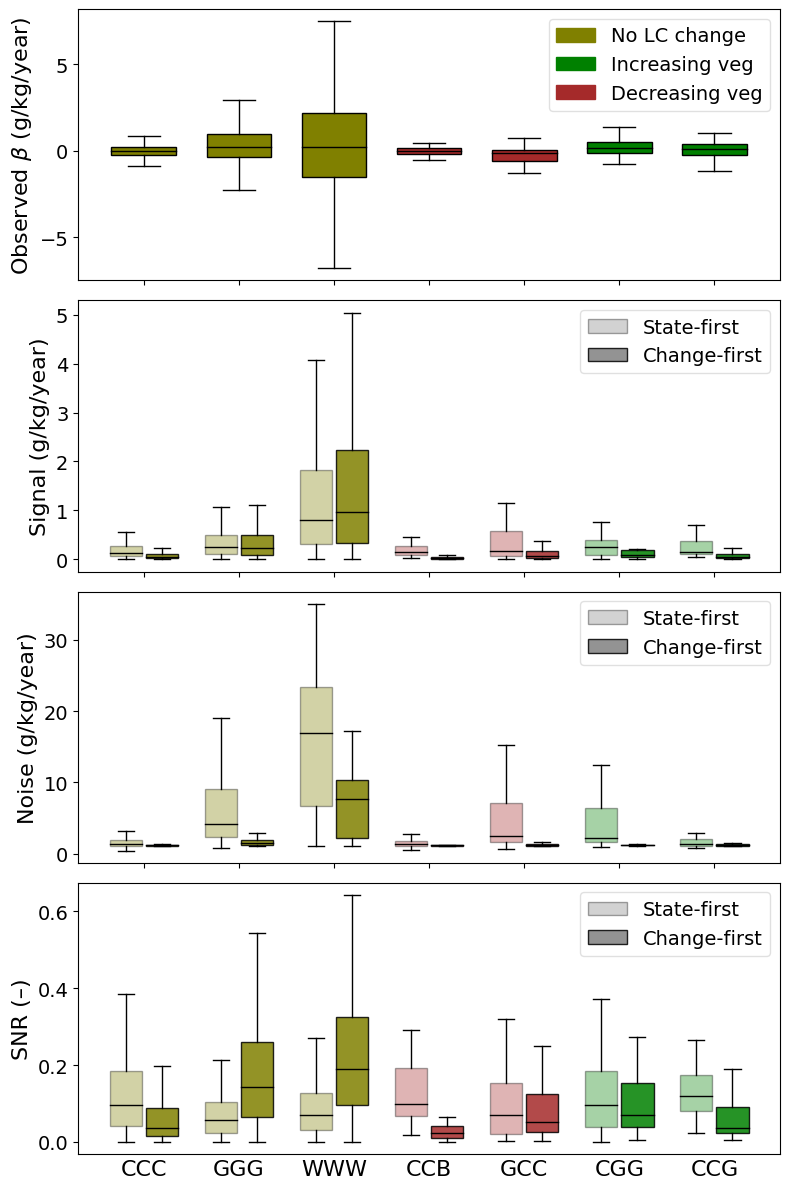

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import numpy as np

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 12), sharex=True)

x = np.arange(len(lc_order))
bar_width = 0.34

# Alphas to distinguish approaches (same LC color across panels)
ALPHA_STATE = 0.35   # lighter = state-first
ALPHA_CHANGE = 0.85  # darker  = change-first

# Shared legend handles for approach (alpha-based)
handle_state = Patch(facecolor='grey', edgecolor='black', alpha=ALPHA_STATE, label='State-first')
handle_change = Patch(facecolor='grey', edgecolor='black', alpha=ALPHA_CHANGE, label='Change-first')

# ────── 1) Top: Observed signal by LC (colored by LC group) ──────
signal_data = [srs.loc[srs['lc_str'] == lc, 'slope_obsv'].dropna() for lc in lc_order]
bp = axs[0].boxplot(
    signal_data,
    positions=x,
    widths=bar_width * 2,
    showfliers=False,
    patch_artist=True,
    medianprops=dict(color='black')
)
for box, lc in zip(bp['boxes'], lc_order):
    box.set_facecolor(color_map[lc])
    box.set_edgecolor('black')

axs[0].set_ylabel(r'Observed $\beta$ (g/kg/year)', fontsize=16)
axs[0].tick_params(axis='both', labelsize=14)

# Legend by LC change group (unchanged)
olive_patch = mpatches.Patch(color='olive', label='No LC change')
green_patch = mpatches.Patch(color='green', label='Increasing veg')
brown_patch = mpatches.Patch(color='brown', label='Decreasing veg')
axs[0].legend(handles=[olive_patch, green_patch, brown_patch],
              fontsize=14, framealpha=0.6, loc='upper right')

# Helper: color all boxes in a boxplot by LC with a given alpha
def color_boxes_by_lc(bp_dict, alpha):
    for i, box in enumerate(bp_dict['boxes']):
        lc = lc_order[i]
        box.set_facecolor(color_map[lc])
        box.set_alpha(alpha)
        box.set_edgecolor('black')

# Positions for side-by-side
positions_left = x - 0.19
positions_right = x + 0.19

# ────── 2) Signal (side-by-side, same LC colors; alpha = approach) ──────
sig_pnt_data = [srs.loc[srs['lc_str'] == lc, 'signal_pnt'].dropna() for lc in lc_order]
sig_srs_data = [srs.loc[srs['lc_str'] == lc, 'signal_srs'].dropna() for lc in lc_order]

bp_left = axs[1].boxplot(sig_pnt_data, positions=positions_left, widths=bar_width,
                         patch_artist=True, medianprops=dict(color='black'), showfliers=False)
bp_right = axs[1].boxplot(sig_srs_data, positions=positions_right, widths=bar_width,
                          patch_artist=True, medianprops=dict(color='black'), showfliers=False)
color_boxes_by_lc(bp_left, alpha=ALPHA_STATE)
color_boxes_by_lc(bp_right, alpha=ALPHA_CHANGE)

axs[1].set_ylabel('Signal (g/kg/year)', fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(handles=[handle_state, handle_change], fontsize=14, framealpha=0.6, loc='upper right')

# ────── 3) Noise (side-by-side, same LC colors; alpha = approach) ──────
noise_pnt_data = [srs.loc[srs['lc_str'] == lc, 'noise_pnt'].dropna() for lc in lc_order]
noise_srs_data = [srs.loc[srs['lc_str'] == lc, 'noise_srs'].dropna() for lc in lc_order]

bp_left = axs[2].boxplot(noise_pnt_data, positions=positions_left, widths=bar_width,
                         patch_artist=True, medianprops=dict(color='black'), showfliers=False)
bp_right = axs[2].boxplot(noise_srs_data, positions=positions_right, widths=bar_width,
                          patch_artist=True, medianprops=dict(color='black'), showfliers=False)
color_boxes_by_lc(bp_left, alpha=ALPHA_STATE)
color_boxes_by_lc(bp_right, alpha=ALPHA_CHANGE)

axs[2].set_ylabel('Noise (g/kg/year)', fontsize=16)
axs[2].tick_params(axis='both', labelsize=14)
axs[2].legend(handles=[handle_state, handle_change], fontsize=14, framealpha=0.6, loc='upper right')

# ────── 4) SNR (side-by-side, same LC colors; alpha = approach) ──────
snr_pnt_data = [srs.loc[srs['lc_str'] == lc, 'snr_pnt'].dropna() for lc in lc_order]
snr_srs_data = [srs.loc[srs['lc_str'] == lc, 'snr_srs'].dropna() for lc in lc_order]

bp_left = axs[3].boxplot(snr_pnt_data, positions=positions_left, widths=bar_width,
                         patch_artist=True, medianprops=dict(color='black'), showfliers=False)
bp_right = axs[3].boxplot(snr_srs_data, positions=positions_right, widths=bar_width,
                          patch_artist=True, medianprops=dict(color='black'), showfliers=False)
color_boxes_by_lc(bp_left, alpha=ALPHA_STATE)
color_boxes_by_lc(bp_right, alpha=ALPHA_CHANGE)

axs[3].set_ylabel('SNR (–)', fontsize=16)  # unitless en dash
axs[3].tick_params(axis='both', labelsize=14)
axs[3].legend(handles=[handle_state, handle_change], fontsize=14, framealpha=0.6, loc='upper right')

# ────── X-axis (shared) ────────────────────────
axs[3].set_xticks(x)
axs[3].set_xticklabels(['CCC', 'GGG', 'WWW','CCB', 'GCC','CGG', 'CCG'],
                       rotation=0, ha='center', fontsize=16)
axs[3].tick_params(axis='x', which='both', length=0)

plt.tight_layout()
plt.savefig('./figure/plot_srs_analysis.pdf', bbox_inches='tight')
plt.show()


## SNR for pairs

In [7]:
pair = pd.read_parquet(f'./metric/pair_predicted_{version}.pq')


In [8]:
pair = pair.drop(columns=['time_pair_y','lc_survey_pair_x','pred_pair'])
pair = pair.rename(columns={'pred_change_pnt':'pred_pnt','pred':'pred_pair','pred_std':'noise_pair',
                            'time_pair_x':'time_pair','lc_survey_pair_y':'lc_survey_pair'})
pair['signal_pnt'] = pair['pred_pnt'].abs()
pair['signal_pair'] = pair['pred_pair'].abs()
pair['snr_pnt'] = pair['signal_pnt']/pair['noise_pnt']
pair['snr_pair'] = pair['signal_pair']/pair['noise_pair']
pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]

In [9]:
# only examine land cover series with population>30
vc = pair['lc_str'].value_counts()
lcl = vc[vc>30].index.tolist() 
pair = pair.loc[pair['lc_str'].isin(lcl)]

In [10]:
# plot in order
lc_order = [
    'Cropland-Cropland','Grassland-Grassland','Woodland-Woodland','Shrubland-Shrubland',
    'Cropland-Bareland','Grassland-Cropland','Woodland-Grassland',
    'Bareland-Cropland','Cropland-Grassland','Shrubland-Woodland','Grassland-Woodland'
]

# Set lc_str as categorical with the desired order
pair['lc_str'] = pd.Categorical(pair['lc_str'], categories=lc_order, ordered=True)

import matplotlib.patches as mpatches

# Define land cover change groups
no_change = ['Cropland-Cropland','Grassland-Grassland','Woodland-Woodland','Shrubland-Shrubland']
decreasing = ['Cropland-Bareland','Grassland-Cropland','Woodland-Grassland']
increasing = ['Bareland-Cropland','Cropland-Grassland','Shrubland-Woodland','Grassland-Woodland']

# Map lc_str to colors
color_map = {}
for lc in lc_order:
    if lc in no_change:
        color_map[lc] = 'olive'
    elif lc in decreasing:
        color_map[lc] = 'brown'
    elif lc in increasing:
        color_map[lc] = 'green'
    else:
        color_map[lc] = 'gray'  # fallback color


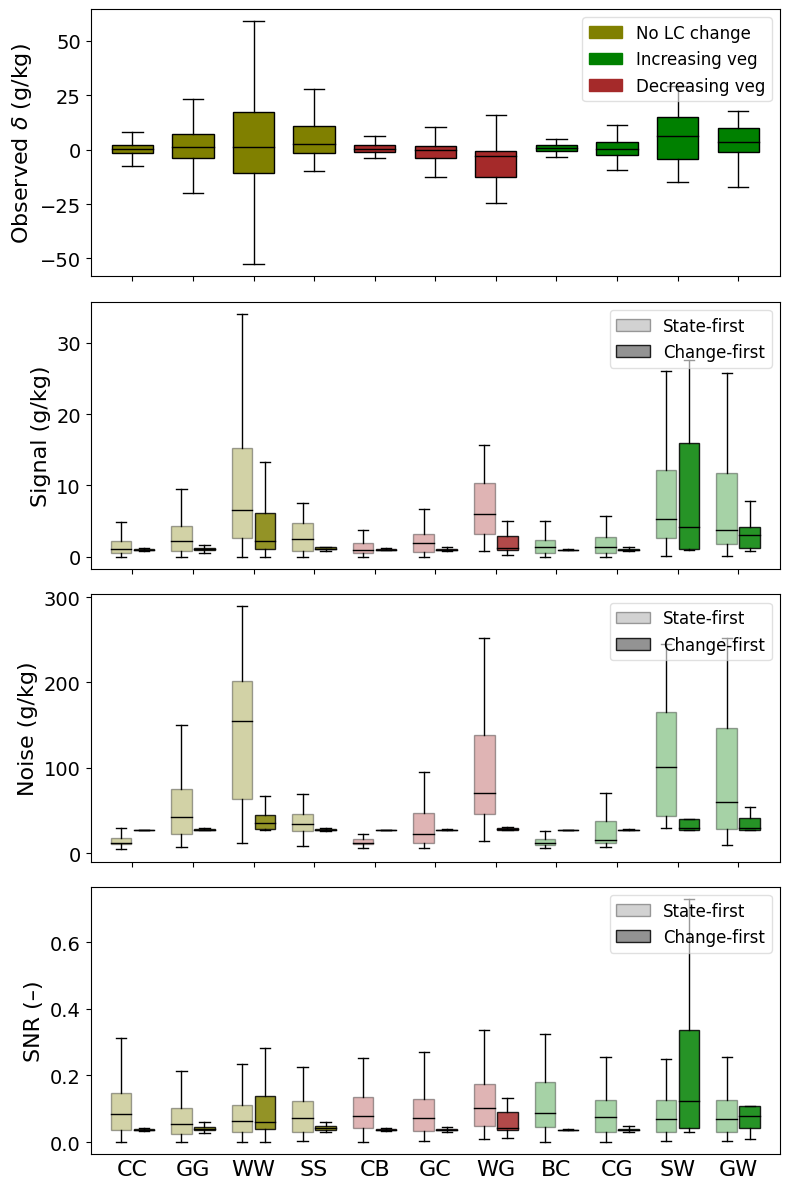

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 12), sharex=True)

x = np.arange(len(lc_order))
bar_width = 0.34

# ───────────────────────────────────────────────
# Distinguish approaches by alpha (same LC colors everywhere)
ALPHA_STATE = 0.35   # State-first (lighter)
ALPHA_CHANGE = 0.85  # Change-first (darker)

# Legend handles for approaches (neutral color + alpha)
handle_pnt = Patch(facecolor='grey', edgecolor='black', alpha=ALPHA_STATE, label='State-first')
handle_srs = Patch(facecolor='grey', edgecolor='black', alpha=ALPHA_CHANGE, label='Change-first')

# ────── helper to color boxplot boxes by LC with a given alpha ──────
def color_boxes_by_lc(bp_dict, alpha):
    for i, box in enumerate(bp_dict['boxes']):
        lc = lc_order[i]
        box.set_facecolor(color_map[lc])
        box.set_alpha(alpha)
        box.set_edgecolor('black')

# ────── 1. Top: Observed signal (colored by LC) ────
signal_data = [pair.loc[pair['lc_str'] == lc, 'soc_change'].dropna() for lc in lc_order]
bp = axs[0].boxplot(
    signal_data,
    positions=x,
    widths=bar_width * 2,
    showfliers=False,
    patch_artist=True,
    medianprops=dict(color='black')
)
for box, lc in zip(bp['boxes'], lc_order):
    box.set_facecolor(color_map[lc])
    box.set_edgecolor('black')

axs[0].set_ylabel(r'Observed $\delta$ (g/kg)', fontsize=16)
axs[0].tick_params(axis='both', labelsize=14)


# Legend by LC change group (unchanged)
olive_patch = mpatches.Patch(color='olive', label='No LC change')
green_patch = mpatches.Patch(color='green', label='Increasing veg')
brown_patch = mpatches.Patch(color='brown', label='Decreasing veg')
axs[0].legend(handles=[olive_patch, green_patch, brown_patch],
              fontsize=12, framealpha=0.6, loc='upper right')

# ────── positions for side-by-side ──────
positions_left = x - 0.19   # State-first
positions_right = x + 0.19  # Change-first

# ────── 2. Signal (side-by-side, same LC colors; alpha by approach) ──────
sig_pnt_data = [pair.loc[pair['lc_str'] == lc, 'signal_pnt'].dropna() for lc in lc_order]
sig_pair_data = [pair.loc[pair['lc_str'] == lc, 'signal_pair'].dropna() for lc in lc_order]

bp_left = axs[1].boxplot(sig_pnt_data, positions=positions_left, widths=bar_width,
                         patch_artist=True, medianprops=dict(color='black'), showfliers=False)
bp_right = axs[1].boxplot(sig_pair_data, positions=positions_right, widths=bar_width,
                          patch_artist=True, medianprops=dict(color='black'), showfliers=False)
color_boxes_by_lc(bp_left, alpha=ALPHA_STATE)
color_boxes_by_lc(bp_right, alpha=ALPHA_CHANGE)

axs[1].set_ylabel('Signal (g/kg)', fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(handles=[handle_pnt, handle_srs], fontsize=12, framealpha=0.6, loc='upper right')

# ────── 3. Noise (side-by-side, same LC colors; alpha by approach) ──────
noise_pnt_data = [pair.loc[pair['lc_str'] == lc, 'noise_pnt'].dropna() for lc in lc_order]
noise_pair_data = [pair.loc[pair['lc_str'] == lc, 'noise_pair'].dropna() for lc in lc_order]

bp_left = axs[2].boxplot(noise_pnt_data, positions=positions_left, widths=bar_width,
                         patch_artist=True, medianprops=dict(color='black'), showfliers=False)
bp_right = axs[2].boxplot(noise_pair_data, positions=positions_right, widths=bar_width,
                          patch_artist=True, medianprops=dict(color='black'), showfliers=False)
color_boxes_by_lc(bp_left, alpha=ALPHA_STATE)
color_boxes_by_lc(bp_right, alpha=ALPHA_CHANGE)

axs[2].set_ylabel('Noise (g/kg)', fontsize=16)
axs[2].tick_params(axis='both', labelsize=14)
axs[2].legend(handles=[handle_pnt, handle_srs], fontsize=12, framealpha=0.6, loc='upper right')

# ────── 4. SNR (side-by-side, same LC colors; alpha by approach) ──────
snr_pnt_data = [pair.loc[pair['lc_str'] == lc, 'snr_pnt'].dropna() for lc in lc_order]
snr_pair_data = [pair.loc[pair['lc_str'] == lc, 'snr_pair'].dropna() for lc in lc_order]

bp_left = axs[3].boxplot(snr_pnt_data, positions=positions_left, widths=bar_width,
                         patch_artist=True, medianprops=dict(color='black'), showfliers=False)
bp_right = axs[3].boxplot(snr_pair_data, positions=positions_right, widths=bar_width,
                          patch_artist=True, medianprops=dict(color='black'), showfliers=False)
color_boxes_by_lc(bp_left, alpha=ALPHA_STATE)
color_boxes_by_lc(bp_right, alpha=ALPHA_CHANGE)

axs[3].set_ylabel('SNR (–)', fontsize=16)  # unitless
axs[3].tick_params(axis='both', labelsize=14)
axs[3].legend(handles=[handle_pnt, handle_srs], fontsize=12, framealpha=0.6, loc='upper right')

# ────── X-axis (shared) ────────────────────────
axs[3].set_xticks(x)
lc_order_show = ['CC','GG','WW','SS','CB','GC','WG','BC','CG','SW','GW']
axs[3].set_xticklabels(lc_order_show, rotation=0, ha='center', fontsize=16)
axs[3].tick_params(axis='x', which='both', length=0)

# ────── Layout and Save/Show ───────────────────
plt.tight_layout()
plt.savefig('./figure/plot_pair_analysis.pdf', bbox_inches='tight')

plt.show()
